## Figure 5

Purity as a function of the $i$-band magnitude
  for the integrated counts.
  The upper panel compares
  the galaxy purity values for BMC (blue solid line),
  TPC (green dashed line), and
  morphological separation (red dashed line).
  The lower panel compares the star purity.
  The $1 \sigma$ error bars are computed following the method
  of Paterno (2003) to avoid the unphysical
  errors of binomial or Poisson statistics.
  
### Reference

Paterno (2003), "Calculating Efficiencies and Their Uncertainties"
http://home.fnal.gov/~paterno/images/effic.pdf

In [61]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
from scipy.special import gammaln
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('legend', fontsize=10)

In [62]:
truth_train = np.loadtxt('../../data/truth_train.dat')
truth_test = np.loadtxt('../../data/truth_test.dat')
mag_i_train = np.loadtxt('../../data/mag_i.train.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')

In [63]:
tpc_test = np.loadtxt('../../data/clens_tpc_test.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('../../data/clens_som_test.mlz', unpack=True, usecols=(2,))
hbc_all = np.loadtxt('../../data/clens_all.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:-len(truth_test)]
hbc_test = hbc_all[-len(truth_test):]
bmc_test = np.loadtxt('../../data/clens_test.bmc')

In [64]:
# read in FLUX_RADIUS and MAG_i and make a classification
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

r_h_test = np.loadtxt('../../data/flux_radius.test.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')
morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

In [65]:
hist_bins = np.arange(17, 25.5, 1)

In [87]:
# http://inspirehep.net/record/669498/files/fermilab-tm-2286.PDF

def calceff(N, k, conf=0.683, tol=5.0e-4, step=1.0e-3, a0=None, dx0=None, output=True):
    
    epsilon = k / N
    
    if a0 is None:
        a0 = epsilon
        
    if dx0 is None:
        dx0 = step
    
    bins = np.arange(0, 1 + step, step)
    
    def get_log_p(N, k):
        p = gammaln(N + 2) - gammaln(k + 1) - gammaln(N - k + 1) + k * np.log(bins) + (N - k) * np.log(1 - bins)
        return p
    
    alpha = np.arange(0, a0, step)
    beta = np.arange(epsilon, 1, step)
    
    log_p = get_log_p(N, k)

    def func(x):
        i = np.argmin(np.abs(bins - x))
        return np.exp(log_p[i])

    found = False

    area_best = 1.0
    alpha_best = alpha[-1]
    beta_best = 1.0

    dxs = np.arange(dx0, 1, step)
    
    for ix, dx in enumerate(dxs):
        
        for ia, a in enumerate(alpha[::-1]):

            b = a + dx
            
            #a = min(a, b)
            #b = max(a, b)
            
            if b > 1 or b < epsilon:
                break
         
            area, err = quad(func, a, b)
                      
            if np.abs(area - conf) < np.abs(area_best - conf):
                area_best = area
                alpha_best = a
                beta_best = b
            
            if np.abs(area - conf) < tol:
                found = True
                break
                
            if area > conf:
                # go back a step, recalculate with smaller step
                alpha_best, beta_best, area_best = calceff(N, k, step=0.8*step, a0=a + step, dx0=dx - step, output=False)

                found = True
                # exit the inner for loop for a
                break
                    
        # exit the outer for loop for dx    
        if found:
            break
    
    if not found:
        alpha_best = epsilon - step
        beta_best = min(1, epsilon + step)
        
    if output:
        print("Done. N = {0}, k = {1}, area: {2:.3f}, alpha: {3:.3f}, beta: {4:.3f}"
              "".format(N, k, area_best, alpha_best, beta_best, step))
            
    return alpha_best, beta_best, area_best

In [88]:
def calc_completeness_purity(truth, classif, mag, p_cut=0.001, bins=np.arange(16, 26, 0.5)):
    '''
    '''
    
    bins = bins[1:]
    result = {}
    
    g_comp_bin = np.zeros(len(bins))
    g_pur_bin = np.zeros(len(bins))
    s_comp_bin = np.zeros(len(bins))    
    s_pur_bin = np.zeros(len(bins))
    
    g_pur_lower_bin = np.zeros(len(bins))
    g_pur_upper_bin = np.zeros(len(bins))

    s_pur_upper_bin = np.zeros(len(bins))
    s_pur_lower_bin = np.zeros(len(bins))

    for i, b in enumerate(bins):
                
        # true galaxies classified as stars
        mask = (mag > -90) & (mag < b)
        gs_bin = ((classif[mask] >= p_cut) & (truth[mask] == 0)).sum().astype(np.float)
        # true galaxies classified as galaxies
        gg_bin = ((classif[mask] < p_cut) & (truth[mask] == 0)).sum().astype(np.float)
        # true stars classified as galaxies
        sg_bin = ((classif[mask] < p_cut) & (truth[mask] == 1)).sum().astype(np.float)
        # true stars classified as stars
        ss_bin = ((classif[mask] >= p_cut) & (truth[mask] == 1)).sum().astype(np.float)

        # galaxy completeness
        g_comp_bin[i] = gg_bin / (gg_bin + gs_bin)    
        # galaxy purity
        g_pur_bin[i] = gg_bin / (gg_bin + sg_bin)
        
        # star completeness
        s_comp_bin[i] = ss_bin / (ss_bin + sg_bin)

        s_pur_bin[i] = ss_bin / (ss_bin + gs_bin)
        
        print("Calculating completenss for {0}...".format(b))

        g_pur_err = calceff(gg_bin + sg_bin, gg_bin)
        g_pur_lower_bin[i] = g_pur_err[0]
        g_pur_upper_bin[i] = g_pur_err[1]
        
        print("Calculating purity for {0}...".format(b))

        s_pur_err = calceff(ss_bin + gs_bin, ss_bin)
        s_pur_lower_bin[i] = s_pur_err[0]
        s_pur_upper_bin[i] = s_pur_err[1]


    result['galaxy_completeness'] = g_comp_bin
    result['galaxy_purity'] = g_pur_bin
    
    result['galaxy_purity_lower'] = g_pur_lower_bin
    result['galaxy_purity_upper'] = g_pur_upper_bin

    result['star_completeness'] = s_comp_bin
    result['star_purity'] = s_pur_bin
    
    result['star_purity_lower'] = s_pur_lower_bin
    result['star_purity_upper'] = s_pur_upper_bin
    
    return result

    
def find_purity_at(truth_test, clf, step=0.001, gc=None, gp=None, sc=None, sp=None):
    
    print("Finding the threshold value...")
    
    if bool(gc) and bool(sc) and bool(gp) and bool(sp):
        raise Exception('Specify only one of gp or sp parameter.')

    pbin = np.arange(0, 1, step)
    
    pure_all = np.zeros(len(pbin))
    comp_all = np.zeros(len(pbin))
    
    for i, p in enumerate(pbin):
        
        # true galaxies classified as stars
        gs = ((clf >= p) & (truth_test == 0)).sum()
        # true galaxies classified as galaxies
        gg = ((clf < p) & (truth_test == 0)).sum()
        # true stars classified as galaxies
        sg = ((clf < p) & (truth_test == 1)).sum()
        # true stars classified as stars
        ss = ((clf >= p) & (truth_test == 1)).sum()
    
        if gc is not None or gp is not None:
            if gg == 0 and sg == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = gg / (gg + sg)
            if gg == 0 and gs == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = gg / (gg + gs)
            
        if sc is not None or sp is not None:
            if ss == 0 and sg == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = ss / (ss + sg)
            if ss == 0 and gs == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = ss / (ss + gs)
    
    if gc is not None:
        ibin = np.argmin(np.abs(comp_all - gc))
        return pbin[ibin], pure_all[ibin]
    
    if gp is not None:
        ibin = np.argmin(np.abs(pure_all - gp))
        return pbin[ibin], comp_all[ibin]
    
    if sc is not None:
        ibin = np.argmin(np.abs(comp_all - sc))
        return pbin[ibin], pure_all[ibin]
    
    if sp is not None:
        ibin = np.argmin(np.abs(pure_all - sp))
        return pbin[ibin], comp_all[ibin]

In [89]:
morph = calc_completeness_purity(truth_test, morph_test, mag_i_test, p_cut=0.5, bins=hist_bins)

Calculating completenss for 18.0...
Done. N = 1235.0, k = 1229.0, area: 0.683, alpha: 0.993, beta: 0.997
Calculating purity for 18.0...
Done. N = 133.0, k = 133.0, area: 1.000, alpha: 0.999, beta: 1.000
Calculating completenss for 19.0...
Done. N = 1821.0, k = 1810.0, area: 0.683, alpha: 0.992, beta: 0.996
Calculating purity for 19.0...
Done. N = 572.0, k = 571.0, area: 0.390, alpha: 0.997, beta: 0.999
Calculating completenss for 20.0...
Done. N = 2972.0, k = 2950.0, area: 0.683, alpha: 0.991, beta: 0.994
Calculating purity for 20.0...
Done. N = 894.0, k = 888.0, area: 0.683, alpha: 0.991, beta: 0.996
Calculating completenss for 21.0...
Done. N = 3905.0, k = 3869.0, area: 0.683, alpha: 0.989, beta: 0.992
Calculating purity for 21.0...
Done. N = 1256.0, k = 1214.0, area: 0.683, alpha: 0.961, beta: 0.972
Calculating completenss for 22.0...
Done. N = 7058.0, k = 6764.0, area: 0.683, alpha: 0.956, beta: 0.961
Calculating purity for 22.0...
Done. N = 1256.0, k = 1214.0, area: 0.683, alpha: 

In [90]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, gc=0.9964, step=0.0001)
bmc_mg = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=hist_bins)

Finding the threshold value...
Calculating completenss for 18.0...
Done. N = 1234.0, k = 1227.0, area: 0.683, alpha: 0.992, beta: 0.997
Calculating purity for 18.0...
Done. N = 134.0, k = 132.0, area: 0.508, alpha: 0.984, beta: 0.986
Calculating completenss for 19.0...
Done. N = 1820.0, k = 1808.0, area: 0.683, alpha: 0.992, beta: 0.995
Calculating purity for 19.0...
Done. N = 573.0, k = 570.0, area: 0.658, alpha: 0.994, beta: 0.996
Calculating completenss for 20.0...
Done. N = 2974.0, k = 2947.0, area: 0.683, alpha: 0.989, beta: 0.993
Calculating purity for 20.0...
Done. N = 892.0, k = 883.0, area: 0.683, alpha: 0.987, beta: 0.994
Calculating completenss for 21.0...
Done. N = 3943.0, k = 3892.0, area: 0.683, alpha: 0.985, beta: 0.989
Calculating purity for 21.0...
Done. N = 1218.0, k = 1199.0, area: 0.683, alpha: 0.981, beta: 0.988
Calculating completenss for 22.0...
Done. N = 6888.0, k = 6771.0, area: 0.683, alpha: 0.982, beta: 0.985
Calculating purity for 22.0...
Done. N = 1426.0, k

In [91]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, sc=0.7145, step=0.0001)
bmc_ms = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=hist_bins)

Finding the threshold value...
Calculating completenss for 18.0...
Done. N = 1247.0, k = 1229.0, area: 0.683, alpha: 0.982, beta: 0.989
Calculating purity for 18.0...
Done. N = 121.0, k = 121.0, area: 1.000, alpha: 0.999, beta: 1.000
Calculating completenss for 19.0...
Done. N = 1842.0, k = 1811.0, area: 0.683, alpha: 0.981, beta: 0.987
Calculating purity for 19.0...
Done. N = 551.0, k = 551.0, area: 1.000, alpha: 0.999, beta: 1.000
Calculating completenss for 20.0...
Done. N = 3011.0, k = 2954.0, area: 0.683, alpha: 0.979, beta: 0.984
Calculating purity for 20.0...
Done. N = 855.0, k = 853.0, area: 0.592, alpha: 0.997, beta: 0.999
Calculating completenss for 21.0...
Done. N = 4028.0, k = 3908.0, area: 0.683, alpha: 0.968, beta: 0.973
Calculating purity for 21.0...
Done. N = 1133.0, k = 1130.0, area: 0.616, alpha: 0.996, beta: 0.998
Calculating completenss for 22.0...
Done. N = 7106.0, k = 6801.0, area: 0.683, alpha: 0.955, beta: 0.960
Calculating purity for 22.0...
Done. N = 1208.0, k

In [92]:
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, gc=0.9964, step=0.0001)
tpc_mg = calc_completeness_purity(truth_test, tpc_test, mag_i_test, p_cut=tpc_p_cut, bins=hist_bins)

Finding the threshold value...
Calculating completenss for 18.0...
Done. N = 1242.0, k = 1226.0, area: 0.683, alpha: 0.984, beta: 0.991
Calculating purity for 18.0...
Done. N = 126.0, k = 123.0, area: 0.611, alpha: 0.975, beta: 0.977
Calculating completenss for 19.0...
Done. N = 1829.0, k = 1797.0, area: 0.683, alpha: 0.979, beta: 0.986
Calculating purity for 19.0...
Done. N = 564.0, k = 550.0, area: 0.683, alpha: 0.969, beta: 0.982
Calculating completenss for 20.0...
Done. N = 2986.0, k = 2933.0, area: 0.683, alpha: 0.980, beta: 0.985
Calculating purity for 20.0...
Done. N = 880.0, k = 857.0, area: 0.683, alpha: 0.968, beta: 0.979
Calculating completenss for 21.0...
Done. N = 3986.0, k = 3878.0, area: 0.683, alpha: 0.971, beta: 0.976
Calculating purity for 21.0...
Done. N = 1175.0, k = 1142.0, area: 0.683, alpha: 0.968, beta: 0.977
Calculating completenss for 22.0...
Done. N = 6967.0, k = 6768.0, area: 0.683, alpha: 0.969, beta: 0.973
Calculating purity for 22.0...
Done. N = 1347.0, k

In [93]:
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, sc=0.7145, step=0.0001)
tpc_ms = calc_completeness_purity(truth_test, tpc_test, mag_i_test, p_cut=tpc_p_cut, bins=hist_bins)

Finding the threshold value...
Calculating completenss for 18.0...
Done. N = 1258.0, k = 1228.0, area: 0.683, alpha: 0.972, beta: 0.980
Calculating purity for 18.0...
Done. N = 110.0, k = 109.0, area: 0.390, alpha: 0.990, beta: 0.992
Calculating completenss for 19.0...
Done. N = 1872.0, k = 1806.0, area: 0.683, alpha: 0.961, beta: 0.970
Calculating purity for 19.0...
Done. N = 521.0, k = 516.0, area: 0.683, alpha: 0.986, beta: 0.995
Calculating completenss for 20.0...
Done. N = 3053.0, k = 2946.0, area: 0.683, alpha: 0.962, beta: 0.969
Calculating purity for 20.0...
Done. N = 813.0, k = 803.0, area: 0.683, alpha: 0.984, beta: 0.992
Calculating completenss for 21.0...
Done. N = 4085.0, k = 3895.0, area: 0.683, alpha: 0.950, beta: 0.957
Calculating purity for 21.0...
Done. N = 1076.0, k = 1060.0, area: 0.683, alpha: 0.982, beta: 0.989
Calculating completenss for 22.0...
Done. N = 7100.0, k = 6786.0, area: 0.683, alpha: 0.954, beta: 0.959
Calculating purity for 22.0...
Done. N = 1214.0, k

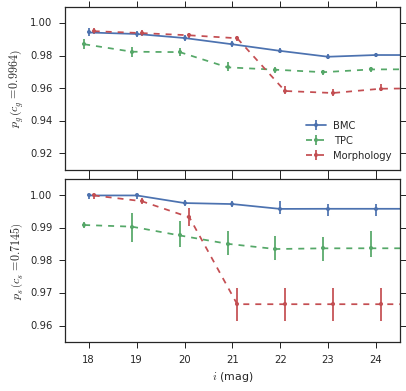

In [94]:
sns.color_palette()
sns.set_style("ticks")

fig = plt.figure(figsize=(6, 6))

ax0 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=3)
ax1 = plt.subplot2grid((6, 3), (3, 0), colspan=3, rowspan=3)

plt.setp(ax0.get_xticklabels(), visible=False)

x_offset = 0.1


ax0.errorbar(hist_bins[1:], bmc_mg['galaxy_purity'],
             yerr=[bmc_mg['galaxy_purity'] - bmc_mg['galaxy_purity_lower'],
                   bmc_mg['galaxy_purity_upper'] - bmc_mg['galaxy_purity']],
             label='BMC', ls='-', marker='o', markersize=4)
ax0.errorbar(hist_bins[1:] - x_offset, tpc_mg['galaxy_purity'],
             yerr=[tpc_mg['galaxy_purity'] - tpc_mg['galaxy_purity_lower'],
                   tpc_mg['galaxy_purity_upper'] - tpc_mg['galaxy_purity']],
             label='TPC', ls='--', marker='o', markersize=4)
ax0.errorbar(hist_bins[1:] + x_offset, morph['galaxy_purity'],
             yerr=[morph['galaxy_purity'] - morph['galaxy_purity_lower'],
                   morph['galaxy_purity_upper'] - morph['galaxy_purity']],
             label='Morphology', ls='--', marker='o', markersize=4)
ax0.legend(loc='lower right')

ax0.set_xlim(17.5, 24.5)
ax0.set_ylim(0.91, 1.01)
#ax0.set_yticks([0.92, 0.94, 0.96, 0.98, 1.0])
ax0.set_ylabel(r'$p_g\left(c_g=0.9964\right)$', fontsize=12)

ax1.errorbar(hist_bins[1:], bmc_ms['star_purity'],
             yerr=[bmc_ms['star_purity'] - bmc_ms['star_purity_lower'],
                   bmc_ms['star_purity_upper'] - bmc_ms['star_purity']],
             label='BMC', ls='-', marker='o', markersize=4)
ax1.errorbar(hist_bins[1:] - x_offset, tpc_ms['star_purity'],
             yerr=[tpc_ms['star_purity'] - tpc_ms['star_purity_lower'],
                   tpc_ms['star_purity_upper'] - tpc_ms['star_purity']],
             label='TPC', ls='--', marker='o', markersize=4)
ax1.errorbar(hist_bins[1:] + x_offset, morph['star_purity'],
             yerr=[morph['star_purity'] - morph['star_purity_lower'],
                   morph['star_purity_upper'] - morph['star_purity']],
             label='Morphology', ls='--', marker='o', markersize=4)

ax1.set_ylabel(r'$p_s\left(c_s=0.7145\right)$', fontsize=12)
ax1.set_xlim(17.5, 24.5)
ax1.set_ylim(0.955, 1.005)
ax1.set_yticks([0.96, 0.97, 0.98, 0.99, 1.00])

ax1.set_xlabel(r'$i$ (mag)')

plt.savefig('../../figures/purity_mag_integrated.pdf')

plt.show()